# Company A - Data Preliminary Analysis

* PCA / ICA & visualization with t-SNE
* Dense NN (no temporal dependence)
* SVM Lasso with Regularization (Recursive Feature Elimination) for Magnitude of initial feature Feature elimination  

## Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import scipy
import sklearn

In [2]:
from tensorflow.keras.models import (Model, Sequential)
from tensorflow.keras.layers import (Input, Dense, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from tensorflow.keras.optimizers import (Adam, SGD)
from tensorflow.keras.regularizers import l1

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

print_fig = True

## Load data & key parameters

In [4]:
data = pd.read_pickle('mod_data.pkl')
print("Column headings:")
print(data.columns)

Column headings:
Index(['Product Made', 'Air consumption', 'Gas consumption', 'Exhaust gas',
       'Speed', 'Pressure', 'Kiln Feed', 'Dust Addition',
       'Moisture Beltweigher', 'Moisture CLC', 'Additive B', 'Additive C',
       'CLC CaO', 'CLC Na2O', 'Surface Area', 'Compacite', 'd50', 'd90',
       'B₂O₃', 'Na₂O'],
      dtype='object')


<span style="color:green"> Is this all of the data that was given? or did you only include some of the information. I thought that there was more data in the original file? 
    
<span style="color:green"> If there is more data in the original file make sure that you still have access to it here. You never know when you will need it. 

In [5]:
# key metrics
col_input = ["Air consumption","Gas consumption","Exhaust gas","Speed","Pressure","Kiln Feed","Dust Addition","Moisture Beltweigher","Moisture CLC","Additive B","Additive C","CLC CaO","CLC Na2O"]
col_output_H = ["Surface Area","Compacite","d50"]
col_output_L = ["d90","B₂O₃","Na₂O"]
prod_type = ['A','B','C','D','F','G','H','I']

### <span style="color:red">Exploratory Analysis</span>

<span style="color:red">**Update:** Here, I made the pair plot. I could not make sense of the plot for all parameters, so I selected only "Exhaust gas","Surface Area", and "Compacite" based on prior correlation study. Color-coding is based on 'Product Made' because that is one of the only few parameters that is categorical. </span>

In [ ]:
# library & dataset
import matplotlib.pyplot as plt
import seaborn as sns
df = data

sns_plot = sns.pairplot(df, kind="reg")
plt.show()

# it is a good idea to save the figures
if print_fig: 
    sns_plot.savefig("corr_plot.png", dpi=1200)

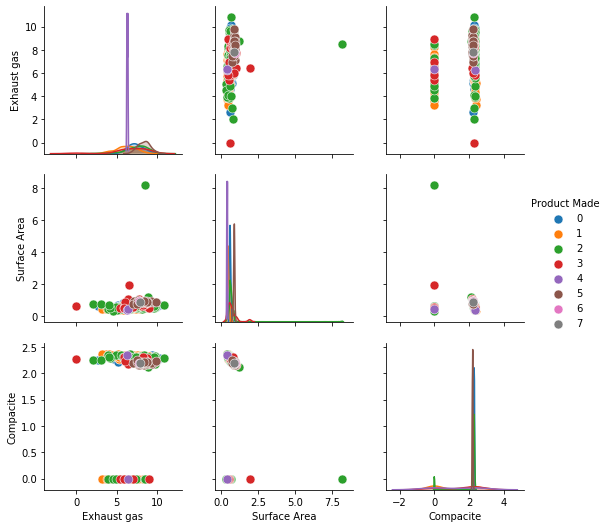

In [13]:
# library & dataset
import matplotlib.pyplot as plt
import seaborn as sns
df = data[['Product Made',"Exhaust gas","Surface Area","Compacite"]]
 

sns_plot = sns.pairplot(df, kind="scatter", vars=["Exhaust gas","Surface Area", "Compacite"], 
             hue='Product Made', plot_kws=dict(s=80, edgecolor="white", linewidth=.5))
plt.show()

# it is a good idea to save the figures
if print_fig: 
    sns_plot.savefig("pairplot.png", dpi=1200)

<span style="color:green"> For the surface area there is clearly one outlier. I would remove that point. Given the amount of variablity in these experiments this is likely a bad measurement not an outlier datapoint. 
    
<span style="color:green"> Compacite is pretty binary. I will talk with Chris about what this means. It might be something that we want to see if a model can predict. If it can predict it then we might be able to understand why it happend. That is the goal. 

## (A) Feature Selection
resource:  
https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b  
https://scikit-learn.org/stable/modules/feature_selection.html

**1. Filter Method**

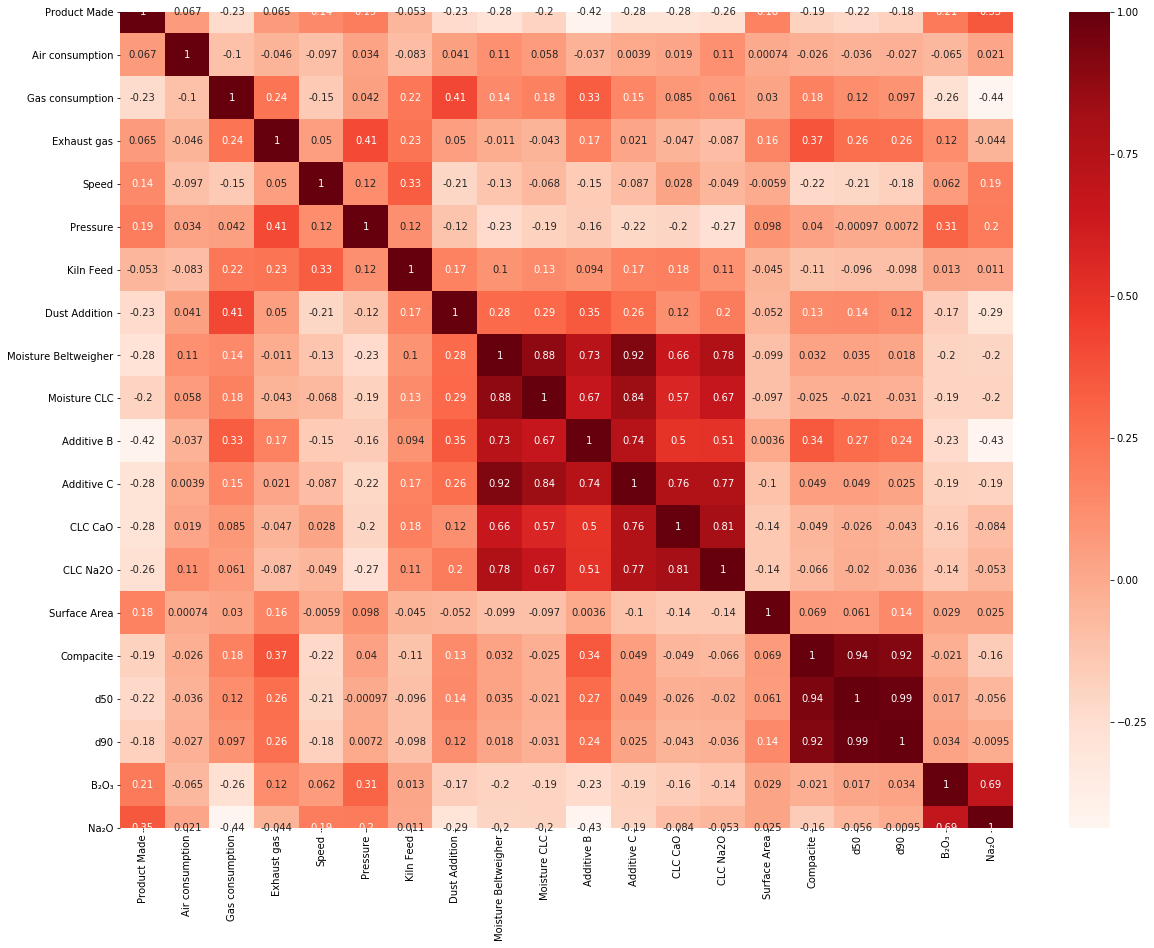

<Figure size 432x288 with 0 Axes>

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(20,15))
cor = data.corr()
sns_plot = sn.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

if print_fig: 
    plt.savefig("corr_2.png", dpi=1200)

<span style="color:green"> I will talk with Chris about this.  

In [14]:
#Correlation with output variable
cor_target = abs(cor["Compacite"])
#Selecting highly correlated features (>0.30)
relevant_features = cor_target[cor_target>0.3] 
relevant_features

Exhaust gas    0.365970
Additive B     0.344023
Compacite      1.000000
d50            0.936217
d90            0.919663
Name: Compacite, dtype: float64

In [15]:
print(data[["Additive B","Exhaust gas"]].corr())

             Additive B  Exhaust gas
Additive B     1.000000     0.172659
Exhaust gas    0.172659     1.000000


**Summary:** 

**2. Wrapper Method with Recursive Feature Elimination (RFE)**

In [16]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 3)
#Transforming data using RFE
X_rfe = rfe.fit_transform(np.array(data[col_input]),np.array(data["Compacite"]))  
#Fitting the data to model
model.fit(X_rfe,np.array(data["Compacite"]))
print(rfe.support_)
print(rfe.ranking_)

[False False False  True False False False False False False False  True
  True]
[11  9  2  1  3  8 10  4  5  6  7  1  1]


In [17]:
#no of features
nof_list=np.arange(1,10)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(np.array(data[col_input]),
                                                        np.array(data["Compacite"]), 
                                                        test_size = 0.2, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 8
Score with 8 features: 0.310235


In [18]:
cols = list(data[col_input].columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 8)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(data[col_input],
                         data["Compacite"])  
#Fitting the data to model
model.fit(X_rfe,data["Compacite"])              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Exhaust gas', 'Speed', 'Pressure', 'Moisture Beltweigher',
       'Moisture CLC', 'Additive B', 'CLC CaO', 'CLC Na2O'],
      dtype='object')


**3. Embedded Method with Lasso**

In [19]:
reg = LassoCV()
reg.fit(data[col_input], data["Compacite"])
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(data[col_input],data["Compacite"]))
coef = pd.Series(reg.coef_, index = data[col_input].columns)

Best alpha using built-in LassoCV: 0.058567
Best score using built-in LassoCV: 0.333285


/Users/joshagar/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [20]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

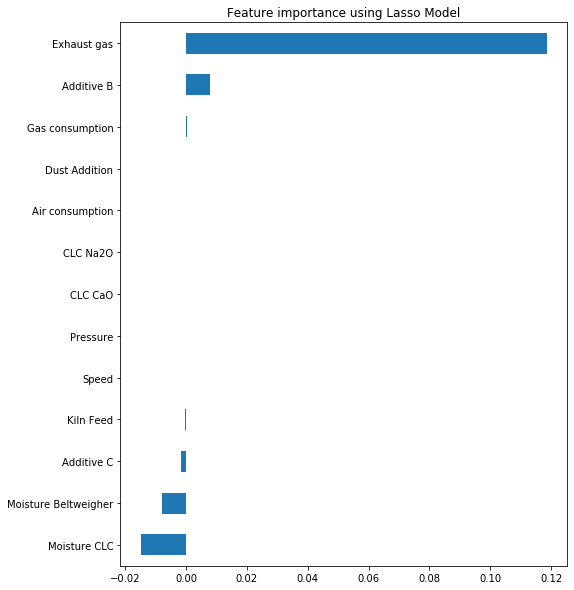

In [21]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## (B) Dense Neural Networks
**<span style="color:red">TODO: change metric from product made to the three major metrics (Surface Area, Compacite, d50)</span>**

Future work: look at attention, https://papers.nips.cc/paper/5268-attentional-neural-network-feature-selection-using-cognitive-feedback.pdf 

##### Normalize data for NN

In [22]:
from sklearn import preprocessing

# removing Product A (="0") because there are too many, thus dominate results
data_in = data[col_input]
data_outH = data[col_output_H]
data_outL = data[col_output_L]

# Create a standard processor object
standard_scaler = preprocessing.StandardScaler()
# Create an object to transform the data to fit std processor
x_scaled = standard_scaler.fit_transform(data_in)
x_scaled2 = standard_scaler.fit_transform(data_outH)
# Run the normalizer on the dataframe
data_in_normalized = pd.DataFrame(x_scaled)
data_outH_normalized = pd.DataFrame(x_scaled2)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_in_normalized), 
                                                    np.array(data["Product Made"]), 
                                                    test_size=0.33)

##### Inspect data shape 

In [17]:
print("input layer:",np.array(data_in_normalized).shape)
print("output layer:",len(data["Product Made"].unique()))
print("output layer:",len(np.unique(y_train)))

input layer: (1116, 13)
output layer: 8
output layer: 8


##### Setting up NN

In [18]:
l1_norm = 1e-4

model = Sequential()
model.add(Dense(50, input_dim=13, activation='relu', activity_regularizer=l1(l1_norm)))
for i in range(10):
    model.add(Dense(50, activation='relu', activity_regularizer=l1(l1_norm)))
model.add(Dense(8, activation='sigmoid')) # or use softmax

##### Compile NN and fit

In [29]:
# set learning rate
lr = 2e-3
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy']) # categorical loss, SGD
# fits the model
model.fit(X_train, y_train, epochs=500, batch_size=100)

Train on 747 samples
Epoch 1/500
747/747 [==============================] - 2s 3ms/sample - loss: 0.8618 - accuracy: 0.6867
Epoch 2/500
747/747 [==============================] - 0s 59us/sample - loss: 0.7639 - accuracy: 0.7363
Epoch 3/500
747/747 [==============================] - 0s 58us/sample - loss: 0.6845 - accuracy: 0.7537
Epoch 4/500
747/747 [==============================] - 0s 68us/sample - loss: 0.6540 - accuracy: 0.7871
Epoch 5/500
747/747 [==============================] - 0s 65us/sample - loss: 0.6047 - accuracy: 0.7952
Epoch 6/500
747/747 [==============================] - 0s 63us/sample - loss: 0.5828 - accuracy: 0.8153
Epoch 7/500
747/747 [==============================] - 0s 71us/sample - loss: 0.5469 - accuracy: 0.8126
Epoch 8/500
747/747 [==============================] - 0s 68us/sample - loss: 0.5306 - accuracy: 0.8273
Epoch 9/500
747/747 [==============================] - 0s 67us/sample - loss: 0.5149 - accuracy: 0.8313
Epoch 10/500
747/747 [======================

747/747 [==============================] - 0s 73us/sample - loss: 0.0245 - accuracy: 0.9973
Epoch 156/500
747/747 [==============================] - 0s 72us/sample - loss: 0.0308 - accuracy: 0.9960
Epoch 157/500
747/747 [==============================] - 0s 77us/sample - loss: 0.0281 - accuracy: 0.9946
Epoch 158/500
747/747 [==============================] - 0s 71us/sample - loss: 0.0261 - accuracy: 0.9960
Epoch 159/500
747/747 [==============================] - 0s 77us/sample - loss: 0.0435 - accuracy: 0.9933
Epoch 160/500
747/747 [==============================] - 0s 85us/sample - loss: 0.0355 - accuracy: 0.9920
Epoch 161/500
747/747 [==============================] - 0s 71us/sample - loss: 0.0395 - accuracy: 0.9933
Epoch 162/500
747/747 [==============================] - 0s 84us/sample - loss: 0.0385 - accuracy: 0.9946
Epoch 163/500
747/747 [==============================] - 0s 85us/sample - loss: 0.0365 - accuracy: 0.9933
Epoch 164/500
747/747 [==============================] - 0s 

747/747 [==============================] - 0s 65us/sample - loss: 0.0137 - accuracy: 1.0000
Epoch 310/500
747/747 [==============================] - 0s 73us/sample - loss: 0.0182 - accuracy: 0.9987
Epoch 311/500
747/747 [==============================] - 0s 72us/sample - loss: 0.0136 - accuracy: 1.0000
Epoch 312/500
747/747 [==============================] - 0s 78us/sample - loss: 0.0161 - accuracy: 0.9973
Epoch 313/500
747/747 [==============================] - 0s 69us/sample - loss: 0.0146 - accuracy: 0.9987
Epoch 314/500
747/747 [==============================] - 0s 84us/sample - loss: 0.0131 - accuracy: 1.0000
Epoch 315/500
747/747 [==============================] - 0s 72us/sample - loss: 0.0132 - accuracy: 1.0000
Epoch 316/500
747/747 [==============================] - 0s 69us/sample - loss: 0.0127 - accuracy: 1.0000
Epoch 317/500
747/747 [==============================] - 0s 72us/sample - loss: 0.0126 - accuracy: 1.0000
Epoch 318/500
747/747 [==============================] - 0s 

747/747 [==============================] - 0s 77us/sample - loss: 0.0099 - accuracy: 1.0000
Epoch 387/500
747/747 [==============================] - 0s 67us/sample - loss: 0.0099 - accuracy: 1.0000
Epoch 388/500
747/747 [==============================] - 0s 78us/sample - loss: 0.0099 - accuracy: 1.0000
Epoch 389/500
747/747 [==============================] - 0s 71us/sample - loss: 0.0099 - accuracy: 1.0000
Epoch 390/500
747/747 [==============================] - 0s 69us/sample - loss: 0.0098 - accuracy: 1.0000
Epoch 391/500
747/747 [==============================] - 0s 74us/sample - loss: 0.0098 - accuracy: 1.0000
Epoch 392/500
747/747 [==============================] - 0s 69us/sample - loss: 0.0098 - accuracy: 1.0000
Epoch 393/500
747/747 [==============================] - 0s 69us/sample - loss: 0.0098 - accuracy: 1.0000
Epoch 394/500
747/747 [==============================] - 0s 69us/sample - loss: 0.0097 - accuracy: 1.0000
Epoch 395/500
747/747 [==============================] - 0s 

##### Evaluate model

In [33]:
# Prediction
predict_raw = model.predict(X_test, verbose=0)
predict_raw.shape

(369, 8)

In [34]:
print(model.metrics_names)
print(model.evaluate(X_test, y_test, verbose=0))

['loss', 'accuracy']
[1.626175726009255, 0.79403794]


In [35]:
# reformat prediction (reshape index to integer)
y_predict = list()
for i in predict_raw:
    y_predict.append(list(i).index(max(i)))
y_predict = np.array(y_predict)

In [36]:
# confusion matrix
result = confusion_matrix(y_test, y_predict)
result.shape

(6, 6)

Text(0.5, 1, 'NN Confusion Matrix')

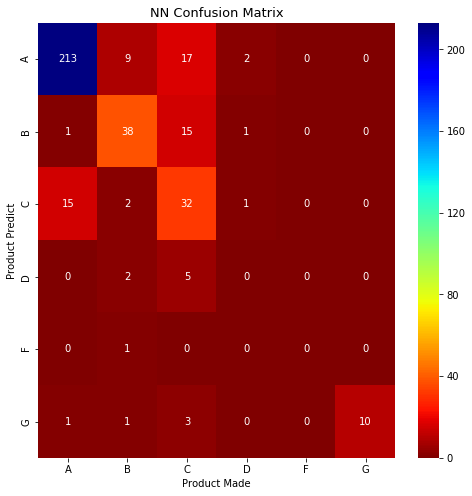

In [39]:
df_cm = pd.DataFrame(result, index = prod_type[:6], columns = prod_type[:6])
plt.figure(figsize = (8,8))
ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap='jet_r')
ax.set(xlabel='Product Made', ylabel='Product Predict')
ax.set_title("NN Confusion Matrix", fontsize=13)

<span style="color:green"> This could be really useful for them. I would be curious to see examples where the desired product is different from what was made. It would be interesting to see if the neural network could have predicted that the produce made would have not been the desired product. 
    
<span style="color:green"> It might be usedful to do tsne where you show what was predicted as right and wrong for a different product. Then you can go back and see if there are any reasons why this might be. 

## (C) Component Analysis + tSNE

**(C.1) Principal Component Analysis (PCA)**

##### Normalize data

In [23]:
from sklearn import preprocessing

# removing Product A (="0") because there are too many, thus dominate results
data_ = data[data["Product Made"]!=0]

# Create a standard processor object
standard_scaler = preprocessing.StandardScaler()
# Create an object to transform the data to fit std processor
x_scaled = standard_scaler.fit_transform(data_.drop(["Product Made"], axis=1))
# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

##### Setup PCA and fit

In [24]:
from sklearn.decomposition import PCA
pca = PCA(8)
result = pca.fit_transform(df_normalized)

Text(0, 0.5, 'cumulative explained variance')

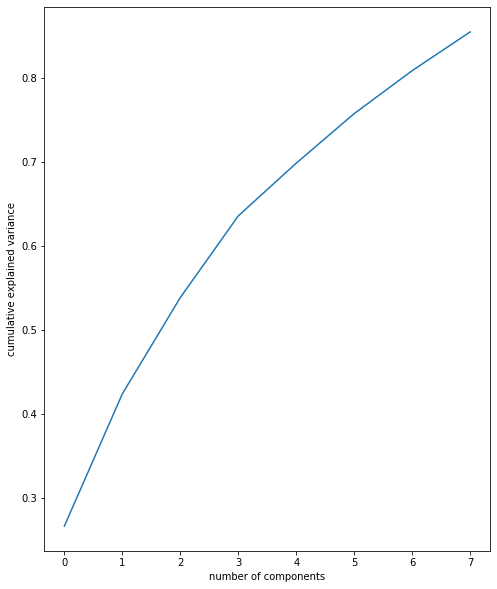

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

##### Visualize with tSNE

In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=True, perplexity=20, n_iter=10000)
tsne_results = tsne.fit_transform(result)
tsne_results.shape

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 382 samples in 0.000s...
[t-SNE] Computed neighbors for 382 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 382 / 382
[t-SNE] Mean sigma: 1.182710
[t-SNE] KL divergence after 250 iterations with early exaggeration: 108.180656
[t-SNE] KL divergence after 10000 iterations: 0.797431


(382, 3)

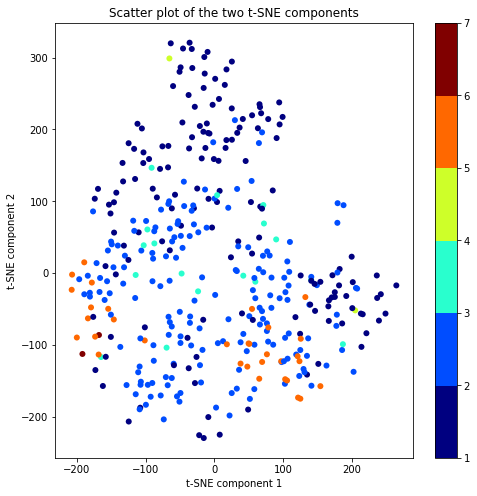

In [27]:
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=data["Product Made"][data["Product Made"]!=0], edgecolor='none', alpha=1,
            cmap=cm.get_cmap('jet', 6))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar();

<span style="color:green"> This is a remarkably bad result. I would also recommend that if you are going to do TSNE with 3 components you should show TSNE with 3 dimensions. TSNE unlike PCA is not ranked. 
   

In [45]:
import plotly.express as px
tsne_results_df = pd.DataFrame(tsne_results)
fig = px.scatter_3d(tsne_results_df, x=0,y=1,z=2, color=data["Product Made"][data["Product Made"]!=0])
fig.show()

##### Visualize with tSNE

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=True, perplexity=20, n_iter=10000)
tsne_results = tsne.fit_transform(result)
tsne_results.shape

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 382 samples in 0.000s...
[t-SNE] Computed neighbors for 382 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 382 / 382
[t-SNE] Mean sigma: 1.182710
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.474136
[t-SNE] KL divergence after 2300 iterations: 0.342507


(382, 2)

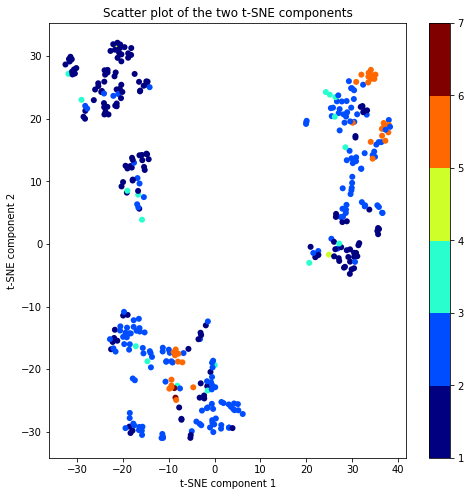

In [29]:
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=data["Product Made"][data["Product Made"]!=0], edgecolor='none', alpha=1,
            cmap=cm.get_cmap('jet', 6))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar();

<span style="color:green"> See, the question is what is the correlations between these 4 groups. You might want to use the NN features and then do TSNE. This might give you a better representations than PCA